In [1]:
from __future__ import print_function, division

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import qgrid

import numpy as np
from numpy import diff
import math

import pandas as pd
import xarray as xr

import climlab
from climlab.solar.insolation import daily_insolation
from climlab.radiation import DailyInsolation
from climlab.radiation import FixedInsolation
from climlab.process import TimeDependentProcess
from climlab.utils import heat_capacity
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
from matplotlib.legend import Legend

from IPython.display import HTML


import scipy as scp
from attrdict import AttrDict
from datetime import datetime

import dask.dataframe as dd

import warnings

import util
import ram_model
import plotting

## Data

Read data and concatenate into one dataset.

level 0 = Surface

level 110 = TOA

(our data is in the order TOA-->Surface)

In [3]:
ds = util.load_soundings()
util.add_monthly_insolation(ds)
ds = util.adjust_lev(ds, nlevels = 95)
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
co2_lev = ds.CO2_list.values

Dropped levels [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 17, 18, 20, 22, 24, 26]


# Climlab

All tendencies must be in K/sec (see Climlab energy_budget documentation and self.heating_rate attribute): https://climlab.readthedocs.io/en/latest/_modules/climlab/process/energy_budget.html#EnergyBudget

In [272]:
timestep = 300 #seconds

############# FIND OUR AVERAGE KAPPA AND ADVECTION ###############

#### Find the surface diffk average over 12 months at CO2 = .00038 ####
mean_diffk_dict = {}
mean_diffk_dict = ram_model.fill_ensemble(ds, mean_diffk_dict, timestep, 
                                                     advection_on = True, turbulence_on = True, 
                                                     advection = None, 
                                                     surface_diffk = None)
surface_diffk_average = ram_model.annual_mean_sfc_diffk(ds, mean_diffk_dict)
print(surface_diffk_average)

#### Find our initial advection #### 
adv_dict = {}
adv_dict = ram_model.fill_ensemble(ds, adv_dict, timestep, 
                                   advection_on = True, turbulence_on = True, 
                                   advection = None, 
                                   surface_diffk = surface_diffk_average)
advection_380_monthly = {}
for m in months:
    advection_380_monthly[m] = adv_dict[0.00038][m].subprocess.Advection.forcing_tendencies['Tatm']


[0.33729347]


In [273]:

############# CREATE OUR MODELS ############    
#### Use our initial advection and surface diffk to run the model #### 

########### RADIATIVE ADVECTIVE TURBULENT #############
rat_dict = {}
rat_dict = ram_model.fill_ensemble(ds, rat_dict, timestep, 
                                   advection_on = True, turbulence_on = True, 
                                   advection = advection_380_monthly,
                                   surface_diffk = surface_diffk_average)



In [274]:
########### RADIATIVE ADVECTIVE #############
ra_dict = {}
ra_dict = ram_model.fill_ensemble(ds, ra_dict, timestep, 
                                   advection_on = True, turbulence_on = False, 
                                   advection = advection_380_monthly,
                                   surface_diffk = surface_diffk_average)



In [275]:
########### RADIATIVE TURBULENT #############
rt_dict = {}
rt_dict = ram_model.fill_ensemble(ds, rt_dict, timestep, 
                                   advection_on = False, turbulence_on = True, 
                                   advection = None,
                                   surface_diffk = surface_diffk_average)

In [276]:
########### RADIATIVE TURBULENT #############
r_dict = {}
r_dict = ram_model.fill_ensemble(ds, r_dict, timestep, 
                                   advection_on = False, turbulence_on = False, 
                                   advection = None,
                                   surface_diffk = surface_diffk_average)

# Output (initial and over time)

In [277]:
month_ds_dict = {} #Empty dictionary to add values into
steps = 10 #43201
fields_dict = {'TdotLW_clr':'z', 'LW_flux_up_clr':'z_bounds', 
               'LW_flux_down_clr':'z_bounds', 'LW_flux_net_clr':'z_bounds', 
               'TdotSW_clr':'z', 'SW_flux_up_clr':'z_bounds', 
               'SW_flux_down_clr':'z_bounds', 'SW_flux_net_clr':'z_bounds'}
model_dict = {'rat':rat_dict,
             'rt':rt_dict,
             'ra':ra_dict,
             'r':r_dict
             }

##### for single model

#original
ex_dict = rat_dict.copy()
save_freq = 1
for month in months:
    month_ds_dict[month] = xr.Dataset(data_vars = {
                                    'co2_lev': ('co2_lev', ds['CO2_list'].values), 
                                    'time': ('time', np.arange(0,((steps+1)*timestep),save_freq*timestep)),
                                    'lev': ('lev', ex_dict[.00038][month].lev),
                                    'lev_full': ('lev_full', np.append(ex_dict[.00038][month].lev, 
                                                                       ex_dict[.00038][month].lev[-1]+(ex_dict[.00038][month].lev[-1]-ex_dict[.00038][month].lev[-2]))),
                                    'lev_bounds': ('lev_bounds', ex_dict[.00038][month].lev_bounds)
                                    })
    lev_da = xr.DataArray(
                        data = np.zeros(
                            (
                             month_ds_dict[month].dims['co2_lev'],
                             month_ds_dict[month].dims['lev'],
                             month_ds_dict[month].dims['time'])), 
                        coords = (
                            (
                             month_ds_dict[month].coords['co2_lev'], 
                             month_ds_dict[month].coords['lev'], 
                             month_ds_dict[month].coords['time'])),
                        dims = (
                                'co2_lev', 
                                'lev',
                                'time')
                    )


    lev_bounds_da = xr.DataArray(
                        data = np.zeros(
                            (
                             month_ds_dict[month].dims['co2_lev'],
                             month_ds_dict[month].dims['lev_bounds'],
                             month_ds_dict[month].dims['time'])), 
                        coords = (
                            (
                                   month_ds_dict[month].coords['co2_lev'], 
                                   month_ds_dict[month].coords['lev_bounds'], 
                                   month_ds_dict[month].coords['time'])),
                        dims = (
                                'co2_lev', 
                                'lev_bounds',
                                'time')
                    )
    lev_full_da = xr.DataArray(
                        data = np.zeros(
                            ( 
                                         month_ds_dict[month].dims['co2_lev'],
                                         month_ds_dict[month].dims['lev_full'],
                                         month_ds_dict[month].dims['time'])), 
                        coords = (
                            (
                                   month_ds_dict[month].coords['co2_lev'], 
                                   month_ds_dict[month].coords['lev_full'], 
                                   month_ds_dict[month].coords['time'])),
                        dims = (
                                'co2_lev', 
                                'lev_full',
                                'time')
                    )
    month_ds_dict[month]['T'] = lev_full_da.copy()
    month_ds_dict[month]['turb_hr'] = lev_full_da.copy()
    month_ds_dict[month]['turbulent_flux'] = lev_bounds_da.copy()
    month_ds_dict[month]['diffk'] = lev_bounds_da.copy()
    month_ds_dict[month]['theta_init'] = lev_da.copy()
    month_ds_dict[month]['theta'] = lev_da.copy()
    month_ds_dict[month]['turb_atm_hr'] = lev_da.copy()
    month_ds_dict[month]['advection'] = lev_full_da.copy()
    month_ds_dict[month]['heat_capacity'] = lev_da.copy()
    
    for var in fields_dict.keys():
        if fields_dict[var] == 'z':
            month_ds_dict[month][var] = lev_da.copy()
        if fields_dict[var] == 'z_bounds':
            month_ds_dict[month][var] = lev_bounds_da.copy()
            
    for co2 in ex_dict.keys():
        #create z coords
        month_ds_dict[month] = month_ds_dict[month].assign_coords(z = ex_dict[co2][month].z)
        month_ds_dict[month] = month_ds_dict[month].assign_coords(z_bounds = ex_dict[co2][month].z_bounds)
        month_ds_dict[month] = month_ds_dict[month].assign_coords(z_full = np.append(ex_dict[co2][month].z, 0))

        month_ds_dict[month]['T'].loc[dict(co2_lev = co2,time = 0)] = np.append(np.array(model_dict['rat'][co2][month].state['Tatm']),np.array(model_dict['rat'][co2][month].state['Ts']))
        month_ds_dict[month]['heat_capacity'].loc[dict(co2_lev = co2,time = 0)] = model_dict['rat'][co2][month].domains['Tatm'].heat_capacity


        month_ds_dict[month]['advection'].loc[dict(co2_lev = co2, time = 0)] = np.append(np.array(model_dict['rat'][co2][month].subprocess.Advection.forcing_tendencies['Tatm']),
                                                 np.array(model_dict['rat'][co2][month].subprocess.Advection.forcing_tendencies['Ts']))

        month_ds_dict[month]['turb_hr'].loc[dict(co2_lev = co2, time = 0)] = np.append(np.array(model_dict['rat'][co2][month].diagnostics['turb_atm_hr']),
                                                     np.array(model_dict['rat'][co2][month].diagnostics['turb_ground_hr']))
        month_ds_dict[month]['turbulent_flux'].loc[dict(co2_lev = co2, time = 0)] = np.append(np.array(model_dict['rat'][co2][month].diagnostics['atm_turbulent_flux']),
                                                     np.array(model_dict['rat'][co2][month].diagnostics['sfc_turbulent_flux']))
        month_ds_dict[month]['diffk'].loc[dict(co2_lev = co2, time = 0)] = np.append(np.array(model_dict['rat'][co2][month].diagnostics['atm_diffk']),
                                                     np.array(model_dict['rat'][co2][month].diagnostics['surface_diffk']))
        month_ds_dict[month]['theta_init'].loc[dict(co2_lev = co2, time = 0)] = model_dict['rat'][co2][month].diagnostics['theta_init'].to_xarray().data
        month_ds_dict[month]['theta'].loc[dict(co2_lev = co2, time = 0)] = model_dict['rat'][co2][month].diagnostics['theta'].to_xarray().data
        month_ds_dict[month]['turb_atm_hr'].loc[dict(co2_lev = co2, time = 0)] = model_dict['rat'][co2][month].diagnostics['turb_atm_hr'].to_xarray().data

        for var in fields_dict.keys():
            month_ds_dict[month][var].loc[dict(co2_lev = co2, time = 0)] = model_dict['rat'][co2][month].diagnostics[var].to_xarray().data


#timestepper
for month in months:
    for co2 in rat_dict.keys():
        for i in range(1,steps):
            #step the model forward
            model_dict['rat'][co2][month].step_forward()
            if i*timestep in month_ds_dict[month]['time']:
                #assign temperature
                month_ds_dict[month]['T'].loc[dict(co2_lev = co2, time = (i*timestep))] = np.append(np.array(model_dict['rat'][co2][month].state['Tatm']),
                                                             np.array(model_dict['rat'][co2][month].state['Ts']))
                #assign heat capacity
                month_ds_dict[month]['heat_capacity'].loc[dict(co2_lev = co2, time = (i*timestep))] = model_dict['rat'][co2][month].domains['Tatm'].heat_capacity
                #assign the variables in the 'field dict' which are typical outputs from climlab
                for var in fields_dict.keys():

                    month_ds_dict[month][var].loc[dict(co2_lev = co2, time = (i*timestep))] = model_dict['rat'][co2][month].diagnostics[var].to_xarray().data


                #assign the variables in the 'advection' field

                month_ds_dict[month]['advection'].loc[dict(co2_lev = co2, time = (i*timestep))] = np.append(np.array(model_dict['rat'][co2][month].subprocess.Advection.forcing_tendencies['Tatm']),
                                                         np.array(model_dict['rat'][co2][month].subprocess.Advection.forcing_tendencies['Ts']))
                #assign the variables in the 'turbulence field'

                month_ds_dict[month]['turb_hr'].loc[dict(co2_lev = co2, time = (i*timestep))] = np.append(np.array(model_dict['rat'][co2][month].diagnostics['turb_atm_hr']),
                                                             np.array(model_dict['rat'][co2][month].diagnostics['turb_ground_hr']))
                month_ds_dict[month]['turbulent_flux'].loc[dict(co2_lev = co2, time = (i*timestep))] = np.append(np.array(model_dict['rat'][co2][month].diagnostics['atm_turbulent_flux']),
                                                             np.array(model_dict['rat'][co2][month].diagnostics['sfc_turbulent_flux']))
                month_ds_dict[month]['diffk'].loc[dict(co2_lev = co2, time = (i*timestep))] = np.append(np.array(model_dict['rat'][co2][month].diagnostics['atm_diffk']),
                                                             np.array(model_dict['rat'][co2][month].diagnostics['surface_diffk']))
                month_ds_dict[month]['theta_init'].loc[dict(co2_lev = co2, time = (i*timestep))] = model_dict['rat'][co2][month].diagnostics['theta_init'].to_xarray().data
                month_ds_dict[month]['theta'].loc[dict(co2_lev = co2, time = (i*timestep))] = model_dict['rat'][co2][month].diagnostics['theta'].to_xarray().data
                month_ds_dict[month]['turb_atm_hr'].loc[dict(co2_lev = co2, time = (i*timestep))] = model_dict['rat'][co2][month].diagnostics['turb_atm_hr'].to_xarray().data



##### multiple models

In [278]:
#original
ex_dict = rat_dict.copy()
save_freq = 1
for month in months:
    month_ds_dict[month] = xr.Dataset(data_vars = {
                                    'model' : ('model', ['rat','rt','ra','r']),
                                    'co2_lev': ('co2_lev', ds['CO2_list'].values), 
                                    'time': ('time', np.arange(0,((steps+1)*timestep),save_freq*timestep)),
                                    'lev': ('lev', ex_dict[.00038][month].lev),
                                    'lev_full': ('lev_full', np.append(ex_dict[.00038][month].lev, 
                                                                       ex_dict[.00038][month].lev[-1]+(ex_dict[.00038][month].lev[-1]-ex_dict[.00038][month].lev[-2]))),
                                    'lev_bounds': ('lev_bounds', ex_dict[.00038][month].lev_bounds)
                                    })
    lev_da = xr.DataArray(
                        data = np.zeros((month_ds_dict[month].dims['model'],month_ds_dict[month].dims['co2_lev'],month_ds_dict[month].dims['lev'],month_ds_dict[month].dims['time'])), 
                        coords = ((month_ds_dict[month].coords['model'], month_ds_dict[month].coords['co2_lev'], month_ds_dict[month].coords['lev'], month_ds_dict[month].coords['time'])),
                        dims = ('model','co2_lev', 'lev','time')
                    )


    lev_bounds_da = xr.DataArray(
                        data = np.zeros((month_ds_dict[month].dims['model'], month_ds_dict[month].dims['co2_lev'],month_ds_dict[month].dims['lev_bounds'],month_ds_dict[month].dims['time'])), 
                        coords = ((month_ds_dict[month].coords['model'], month_ds_dict[month].coords['co2_lev'], month_ds_dict[month].coords['lev_bounds'], month_ds_dict[month].coords['time'])),
                        dims = ('model','co2_lev', 'lev_bounds','time')
                    )
    lev_full_da = xr.DataArray(
                        data = np.zeros((month_ds_dict[month].dims['model'], month_ds_dict[month].dims['co2_lev'],month_ds_dict[month].dims['lev_full'],month_ds_dict[month].dims['time'])), 
                        coords = ((month_ds_dict[month].coords['model'], month_ds_dict[month].coords['co2_lev'], month_ds_dict[month].coords['lev_full'], month_ds_dict[month].coords['time'])),
                        dims = ('model','co2_lev', 'lev_full','time')
                    )
    month_ds_dict[month]['T'] = lev_full_da.copy()
    month_ds_dict[month]['turb_hr'] = lev_full_da.copy()
    month_ds_dict[month]['turbulent_flux'] = lev_bounds_da.copy()
    month_ds_dict[month]['diffk'] = lev_bounds_da.copy()
    month_ds_dict[month]['theta_init'] = lev_da.copy()
    month_ds_dict[month]['theta'] = lev_da.copy()
    month_ds_dict[month]['turb_atm_hr'] = lev_da.copy()
    month_ds_dict[month]['advection'] = lev_full_da.copy() ### Why is advection on lev_full? Is there advection into the ground?
    month_ds_dict[month]['heat_capacity'] = lev_da.copy()
    
    for var in fields_dict.keys():
        if fields_dict[var] == 'z':
            month_ds_dict[month][var] = lev_da.copy()
        if fields_dict[var] == 'z_bounds':
            month_ds_dict[month][var] = lev_bounds_da.copy()
            
    for co2 in ex_dict.keys():
        for dict_name in model_dict.keys():
            #create z coords
            month_ds_dict[month] = month_ds_dict[month].assign_coords(z = ex_dict[co2][month].z)
            month_ds_dict[month] = month_ds_dict[month].assign_coords(z_bounds = ex_dict[co2][month].z_bounds)
            month_ds_dict[month] = month_ds_dict[month].assign_coords(z_full = np.append(ex_dict[co2][month].z, -0.5))
            
            month_ds_dict[month]['T'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].state['Tatm']),
                                                         np.array(model_dict[dict_name][co2][month].state['Ts']))
            month_ds_dict[month]['heat_capacity'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = model_dict[dict_name][co2][month].domains['Tatm'].heat_capacity

            if 'a' in dict_name:
                month_ds_dict[month]['advection'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].subprocess.Advection.forcing_tendencies['Tatm']),
                                                         np.array(model_dict[dict_name][co2][month].subprocess.Advection.forcing_tendencies['Ts']))
            
            if 't' in dict_name:
                month_ds_dict[month]['turb_hr'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].diagnostics['turb_atm_hr']),
                                                             np.array(model_dict[dict_name][co2][month].diagnostics['turb_ground_hr']))
                month_ds_dict[month]['turbulent_flux'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].diagnostics['atm_turbulent_flux']),
                                                             np.array(model_dict[dict_name][co2][month].diagnostics['sfc_turbulent_flux']))
                month_ds_dict[month]['diffk'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].diagnostics['atm_diffk']),
                                                             np.array(model_dict[dict_name][co2][month].diagnostics['surface_diffk']))
                month_ds_dict[month]['theta_init'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = model_dict[dict_name][co2][month].diagnostics['theta_init'].to_xarray().data
                month_ds_dict[month]['theta'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = model_dict[dict_name][co2][month].diagnostics['theta'].to_xarray().data
                month_ds_dict[month]['turb_atm_hr'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = model_dict[dict_name][co2][month].diagnostics['turb_atm_hr'].to_xarray().data

            for var in fields_dict.keys():
                month_ds_dict[month][var].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = model_dict[dict_name][co2][month].diagnostics[var].to_xarray().data


# Timestepping (and saving output)

In [279]:
#timestepper
for month in months:
    for dict_name in model_dict.keys():
        for co2 in rat_dict.keys():
            tmp_model = model_dict[dict_name][co2][month]
            for i in range(1,steps):
                #step the model forward
                tmp_model.step_forward()
                if i*timestep in month_ds_dict[month]['time']:
                    loc_dict = dict(co2_lev = co2, time = (i*timestep), model = dict_name)
                    #assign temperature
                    month_ds_dict[month]['T'].loc[loc_dict] = np.append(np.array(tmp_model.state['Tatm']),
                                                                 np.array(tmp_model.state['Ts']))
                    #assign heat capacity
                    month_ds_dict[month]['heat_capacity'].loc[loc_dict] = tmp_model.domains['Tatm'].heat_capacity
                    #assign the variables in the 'field dict' which are typical outputs from climlab
                    for var in fields_dict.keys():

                        month_ds_dict[month][var].loc[loc_dict] = tmp_model.diagnostics[var].to_xarray().data


                    #assign the variables in the 'advection' field
                    if 'a' in dict_name:

                        month_ds_dict[month]['advection'].loc[loc_dict] = np.append(np.array(tmp_model.subprocess.Advection.forcing_tendencies['Tatm']),
                                                                 np.array(tmp_model.subprocess.Advection.forcing_tendencies['Ts']))
                    #assign the variables in the 'turbulence field'
                    if 't' in dict_name:

                        # WHY ONLY .to_xarray().data on some of the diagnostics? What is the point of this?
                        month_ds_dict[month]['turb_hr'].loc[loc_dict] = np.append(np.array(tmp_model.diagnostics['turb_atm_hr']),
                                                                     np.array(tmp_model.diagnostics['turb_ground_hr']))
                        month_ds_dict[month]['turbulent_flux'].loc[loc_dict] = np.append(np.array(tmp_model.diagnostics['atm_turbulent_flux']),
                                                                     np.array(tmp_model.diagnostics['sfc_turbulent_flux']))
                        month_ds_dict[month]['diffk'].loc[loc_dict] = np.append(np.array(tmp_model.diagnostics['atm_diffk']),
                                                                     np.array(tmp_model.diagnostics['surface_diffk']))
                        month_ds_dict[month]['theta_init'].loc[loc_dict] = tmp_model.diagnostics['theta_init'].to_xarray().data
                        month_ds_dict[month]['theta'].loc[loc_dict] = tmp_model.diagnostics['theta'].to_xarray().data
                        month_ds_dict[month]['turb_atm_hr'].loc[loc_dict] = tmp_model.diagnostics['turb_atm_hr'].to_xarray().data



In [280]:
###create a dict of output names and the z bounds they align with
output_dict = {}
output_dict['bounds'] = {'Tatm':'z','TdotLW_clr':'z', 'LW_flux_up_clr':'z_bounds', 
               'LW_flux_down_clr':'z_bounds', 'LW_flux_net_clr':'z_bounds', 
               'TdotSW_clr':'z', 'SW_flux_up_clr':'z_bounds', 
               'SW_flux_down_clr':'z_bounds', 'SW_flux_net_clr':'z_bounds',
               'theta_init':'z', 'theta':'z', 'dtheta_dz':'z_bounds', 'atm_diffk':'z_bounds', 
               'atm_turbulent_flux':'z_bounds','turb_atm_hr':'z', 
               'turb_hr':'z', 'advection_Tatm':'z'}
atm_process_dict = {'Tatm':'Atmospheric Temperature (K)',
                    'atm_diffk':r'Atmospheric $\kappa$ ($\frac{m^2}{s}$)',
                    'dtheta_dz':r'$\frac{d\theta}{dz}$ ($\frac{K}{m}$)',
                    'theta':r'$\theta$',
                    'SW_flux_net_clr':r'Shortwave Flux ($\frac{W}{m^2}$)',
                    'LW_flux_net_clr':r'Longwave Flux ($\frac{W}{m^2}$)', 
                    'TdotLW_clr':r'Longwave Heating Rate ($\frac{K}{s}$)',
                    'TdotSW_clr':r'Shortwave Heating Rate ($\frac{K}{s}$)',
                    'turb_atm_hr':r'Turbulent Heating Rate ($\frac{K}{s}$)',
                    'advection_Tatm':r'Advective Heating Rate ($\frac{K}{s}$)',
                   'atm_turbulent_flux':'Turbulent Flux'}
single_level_process = {'LW_sfc_clr':r'Surface Longwave Flux ($\frac{W}{m^2}$)', 
                        'Ts': 'Surface Temperature (K)', 
                        'ASRclr':r'Absorbed Solar Radiation, ($\frac{W}{m^2}$)', 
                        'SW_sfc_clr':r'Surface Shortwave Flux ($\frac{W}{m^2}$)', 
                        'total_sfc_flux':r'Total Surface Flux ($\frac{W}{m^2}$)', 
                        'dtheta_dz_near_surf_init':r'$\frac{d\theta}{dz}$ ($\frac{K}{m}$)', 
                        'surface_diffk':r'Surface $\kappa$ ($\frac{m^2}{s}$)', 
                        'sfc_turbulent_flux':r'Surface Turbulent Flux ($\frac{W}{m^2}$)', 
                        'turb_ground_hr':r'Surface Turbulent Heating Rate ($\frac{K}{s}$)', 
                        'advection_Ts':r'Surface Advection ($\frac{K}{s}$)', 
                        'OLR':r'Outgoing Longwave Radiation ($\frac{W}{m^2}$)'}

for month in months:
    month_ds_dict[month].to_netcdf(f'./output/{month}_300s_43200ts_ds')

#### parameters for plots

(700, 650)

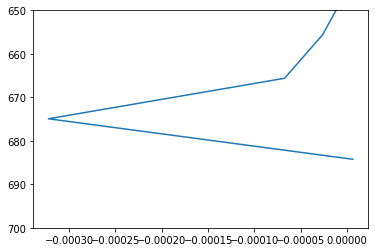

In [281]:
x = month_ds_dict['August']['turb_hr'].sel(co2_lev = .00038, model = 'rat').isel(time = 0)
y = month_ds_dict['August']['lev_full']
plt.plot(x,y)
plt.ylim([700,650])

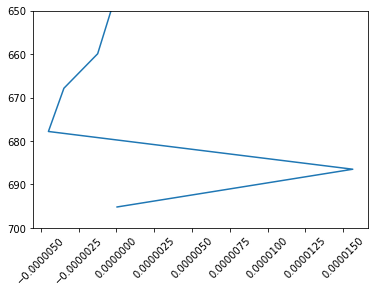

In [282]:
x = month_ds_dict['December']['turb_hr'].sel(co2_lev = .00038, model = 'rat').isel(time = 0)
y = month_ds_dict['December']['lev_full']
plt.plot(x,y)
plt.ylim([700,650])
plt.xticks(rotation = 45);

(700, 0)

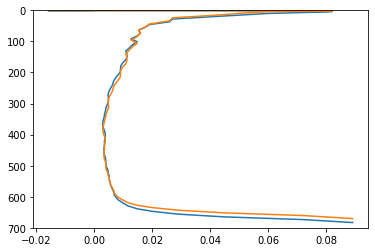

In [297]:
plt.plot(rat_dict[0.000380]['August'].subprocess.Turbulence.diagnostics['dtheta_dz'], rat_dict[0.000380]['January'].lev_bounds[:-1])
plt.plot(
    np.diff(month_ds_dict['August'].sel(time = timestep*9, co2_lev = .00038, model = 'rat').theta)/
    np.diff(month_ds_dict['August'].sel(time = timestep*9, co2_lev = .00038, model = 'rat').z),
    month_ds_dict['August'].sel(time = timestep*9, co2_lev = .00038, model = 'rat').lev_bounds[1:-1]
)
plt.ylim([700,0])

(750, -50)

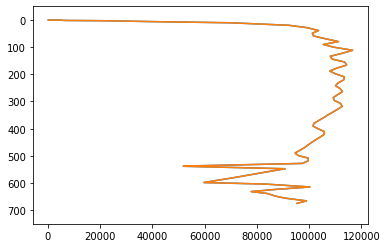

In [169]:
plt.plot(climlab.utils.heat_capacity.atmosphere(np.diff(month_ds_dict['August'].lev_bounds)), month_ds_dict['August'].lev)
plt.ylim(750,-50)

plt.plot(month_ds_dict['August'].sel(time = 0, co2_lev = .00038, model = 'rat').heat_capacity, month_ds_dict['August'].lev)
plt.ylim(750,-50)



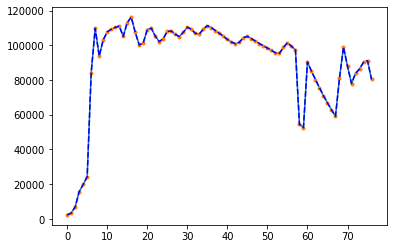

In [163]:
plt.plot(heat_capacity.atmosphere(rat_dict[0]['April'].domains['Tatm'].axes['lev'].delta), label = 'climlab')
plt.plot(heat_capacity.atmosphere(np.diff(rat_dict[0]['April'].domains['Tatm'].axes['lev'].bounds)), '.', label = 'mine')
plt.plot(month_ds_dict['April'].heat_capacity.sel(time = 0 , co2_lev = .00038, model = 'rat'), 'b--')

In [21]:
###select CO2 concentrations and times to look at
CO2_conc1 = .00038
CO2_conc2 = .00076
time1 = (0)*timestep
time2 = 1*timestep
time3 = 2*timestep
time4 = 5*timestep
time5 = 7*timestep
time6 = 9*timestep
time7 = 12*timestep
time8 = 15*timestep
time9 = 18*timestep
time10 = 200*timestep

month1 = 'December'
month2 = 'April'

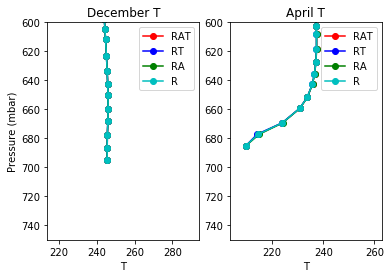

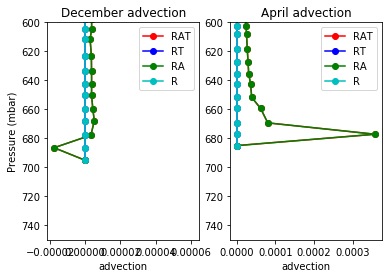

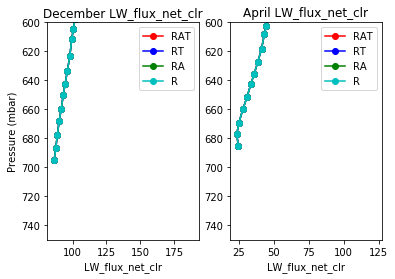

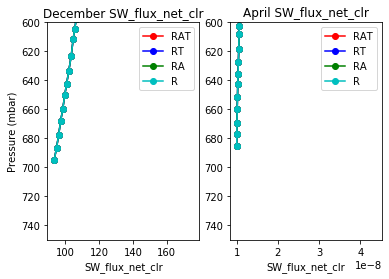

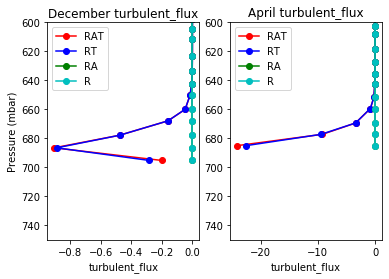

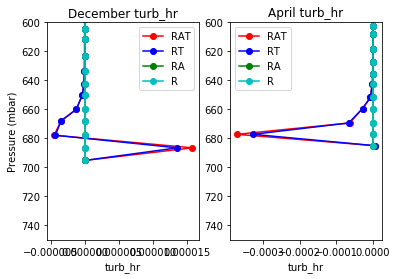

In [89]:
time = month_ds_dict['January']['time'][-2]
for output in ['T','advection', 'LW_flux_net_clr', 'SW_flux_net_clr', 'turbulent_flux', 'turb_hr']:
    fig, axes = plt.subplots(1, 2)
    for idx, month in enumerate([month1, month2]):
        ax = axes[idx]
        ax.plot(month_ds_dict[month].sel(co2_lev = .00038, model = 'rat', time = time)[output],
                month_ds_dict[month].sel(co2_lev = .00038, model = 'rat', time = time)['lev_full'], "-o",
                color = 'r',
                label = 'RAT'
               )
        ax.plot(month_ds_dict[month].sel(co2_lev = .00038, model = 'rt', time = time)[output],
                month_ds_dict[month].sel(co2_lev = .00038, model = 'rt', time = time)['lev_full'], "-o",
                color = 'b',
                label = 'RT')
        ax.plot(month_ds_dict[month].sel(co2_lev = .00038, model = 'ra', time = time)[output],
                month_ds_dict[month].sel(co2_lev = .00038, model = 'ra', time = time)['lev_full'],"-o",
                color = 'g',
                label = 'RA')
        ax.plot(month_ds_dict[month].sel(co2_lev = .00038, model = 'r', time = time)[output],
                month_ds_dict[month].sel(co2_lev = .00038, model = 'r', time = time)['lev_full'], "-o",
                color = 'c',
                label = 'R')
        ax.legend()
        ax.set_xlabel(output)
        axes[0].set_ylabel('Pressure (mbar)')
        ax.set_ylim([750,600])
        ax.set_title(month + ' ' + output)

In [ ]:
month_ds_dict[month].sel(co2_lev = .00038, model = 'r', time = time)['output']

In [114]:
rat_dict[0.0]['April'].domains['Tatm'].lev

### find entire column energy balance

In [194]:
#time we're looking at
time = month_ds_dict['January']['time'][-3]
month = month1
co2 = 0.00038
timestep = 300

In [195]:
energy_budget_df = pd.DataFrame(index = pd.MultiIndex(levels=[ds.month.values, ['rat','ra','rt','r']],
           codes=[[0,0,0,0, 1, 1,1,1, 2, 2,2,2, 3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8,8,9,9,9,9,10,10,10,10, 11, 11, 11, 11], 
                  [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3, 0, 1, 2, 3,]],
                                                     names = ['month','model']), 
                                columns = ['ATM_mass','TOA_rad','SFC_rad','SFC_turb','ATM_adv','ATM_heat','energy_budget'])

In [196]:
for idx_month, month in enumerate(ds.month.values):
    for idx_mod, model in enumerate(['rat','ra','rt','r']):
        tmp_ds = month_ds_dict[month].sel(model = model, co2_lev = co2, time = time)
        #atmospheric mass
        energy_budget_df.loc[month, model]['ATM_mass'] = month_ds_dict[month].sel(model = model, co2_lev = co2, time = time)['heat_capacity'].sum().values #Pa
        
        #TOA Frad
        energy_budget_df.loc[month, model]['TOA_rad'] = (month_ds_dict[month].sel(model = model, 
            co2_lev = co2, time = time)['SW_flux_net_clr'][0] - month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['LW_flux_net_clr'][0]).values #W/m2
        #Surface Frad
        energy_budget_df.loc[month, model]['SFC_rad'] = (month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['SW_flux_net_clr'][-1] - month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['LW_flux_net_clr'][-1]).values #W/m2
        #Surface Turbulence
        energy_budget_df.loc[month, model]['SFC_turb'] = (month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['turbulent_flux'])[-1].values #W/m2
        
        #Atmospheric Advection
        energy_budget_df.loc[month, model]['ATM_adv'] = (month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['advection'][:-1].values * month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['heat_capacity']).values.sum()
        
        #Atmospheric Heating
        energy_budget_df.loc[month, model]['ATM_heat'] = ((month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = (time+timestep))['T'].values - month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = (time))['T'].values)[:-1]/(timestep) * month_ds_dict[month].sel(
            model = model, 
            co2_lev = co2, time = time)['heat_capacity']).sum().values
    
        
        energy_budget_df.loc[month, model]['energy_budget'] = (energy_budget_df.loc[month, model]['TOA_rad'] - 
                                                               energy_budget_df.loc[month, model]['SFC_rad'] +  
                                                               energy_budget_df.loc[month, model]['SFC_turb'] + 
                                                               energy_budget_df.loc[month, model]['ATM_adv'] - 
                                                               energy_budget_df.loc[month, model]['ATM_heat'])

In [235]:
energy_budget_df2.loc['August']

,ATM_heat,TOA_rad,SFC_heat,Advection,energy_budget
model,,,,,
rat,-0.020333131552402912,-113.17102718331165,[-7.5901353433202505],120.939,[15.378387233471159]
ra,40.543665837414615,-113.16788373326227,[-32.770444266802656],120.939,[-0.0021593619640754014]
rt,-117.44103923197545,-113.15786129886922,[-9.270689119468205],0,[13.553867052574432]
r,-80.29961957126048,-113.15475581981,[-32.84655486179547],0,[-0.008581386754059395]


In [230]:
rat_dict[0.0]['August'].domains['Ts'].heat_capacity

array([4181300.])

In [234]:
climlab.utils.heat_capacity.ocean(1.)

4181300.0

In [225]:
energy_budget_df.loc['August']

,ATM_mass,TOA_rad,SFC_rad,SFC_turb,ATM_adv,ATM_heat,energy_budget
model,,,,,,,
rat,6958588.511224489,-113.17102718331165,-32.84049232968814,-25.24625334130737,120.939,-0.020333131552402912,15.3825
ra,6958588.511224489,-113.16788373326227,-32.794398817645295,0.0,120.939,40.543665837414615,0.0217952
rt,6958588.511224489,-113.15786129886922,-32.89068190556584,-24.151114834910437,0,-117.44103923197545,13.0227
r,6958588.511224489,-113.15475581981,-32.84551680043988,0.0,0,-80.29961957126048,-0.00961945


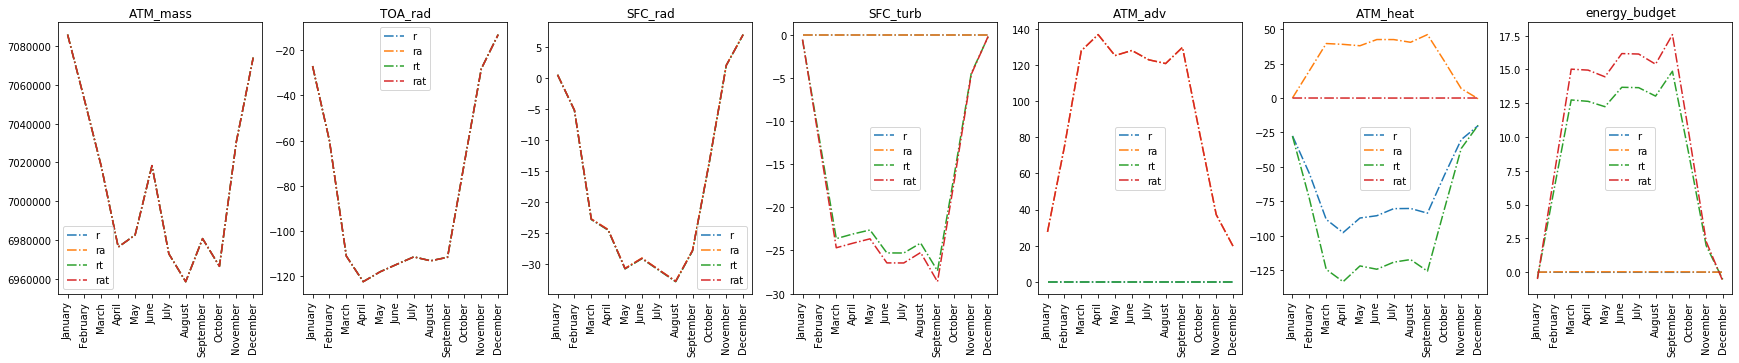

In [198]:
fig, axes = plt.subplots(1,7, figsize = (30, 5))
colors = cm.twilight(np.linspace(0,1,4))
for idx, result in enumerate(energy_budget_df.columns.values):
    ax = axes[idx]
    for model in ['r','ra','rt','rat']:
        ax.plot(energy_budget_df.query(f'model == "{model}"').index.get_level_values(0), energy_budget_df.query(f'model == "{model}"')[result], '-.', label = f'{model}')
    ax.legend()
    ax.set_xticklabels(labels = energy_budget_df.query(f'model == "{model}"').index.get_level_values(0),rotation = 90);
    ax.set_title(result)

## Alternative Budget

In [216]:
energy_budget_df2 = pd.DataFrame(index = pd.MultiIndex(levels=[ds.month.values, ['rat','ra','rt','r']],
           codes=[[0,0,0,0, 1, 1,1,1, 2, 2,2,2, 3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8,8,9,9,9,9,10,10,10,10, 11, 11, 11, 11], 
                  [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3,0, 1, 2, 3, 0, 1, 2, 3,]],
                                                     names = ['month','model']), 
                                columns = ['ATM_heat','TOA_rad','SFC_heat','Advection','energy_budget'])
for idx_month, month in enumerate(ds.month.values):
    for idx_mod, model in enumerate(['rat','ra','rt','r']):
        #tmp_ds = month_ds_dict[month].sel(model = model, co2_lev = co2, time = time)
        #Surface heating
        energy_budget_df2.loc[month, model]['SFC_heat'] = (month_ds_dict[month].sel(
        model = model, 
        co2_lev = co2, time = (time+timestep))['T'].values - month_ds_dict[month].sel(
        model = model, 
        co2_lev = co2, time = (time))['T'].values)[-1]/(timestep) * rat_dict[0][month].domains['Ts'].heat_capacity
        
        #TOA Frad
        energy_budget_df2.loc[month, model]['TOA_rad'] = (month_ds_dict[month].sel(model = model, 
        co2_lev = co2, time = time)['SW_flux_net_clr'][0] - month_ds_dict[month].sel(
        model = model, 
        co2_lev = co2, time = time)['LW_flux_net_clr'][0]).values #W/m2        

        #Atmospheric Heating
        energy_budget_df2.loc[month, model]['ATM_heat'] = ((month_ds_dict[month].sel(
        model = model, 
        co2_lev = co2, time = (time+timestep))['T'].values - month_ds_dict[month].sel(
        model = model, 
        co2_lev = co2, time = (time))['T'].values)[:-1]/(timestep) * month_ds_dict[month].sel(
        model = model, 
        co2_lev = co2, time = time)['heat_capacity']).sum().values

        #advective flux at each level
        energy_budget_df2.loc[month, model]['Advection'] = (month_ds_dict[month].sel(
        model = model, 
        co2_lev = co2, time = time)['advection'][:-1].values * month_ds_dict[month].sel(
        model = model, 
        co2_lev = co2, time = time)['heat_capacity']).values.sum()

        #energy budget
        energy_budget_df2.loc[month, model]['energy_budget'] = energy_budget_df2.loc[month, model]['TOA_rad'] - energy_budget_df2.loc[month, model]['SFC_heat'] - energy_budget_df2.loc[month, model]['ATM_heat'] + energy_budget_df2.loc[month, model]['Advection']


ATM_heat              TOA_rad  \
month     model                                               
January   rat     0.002784841758721188   -27.03318446680342   
          ra      0.062385963370593434   -27.03305211310027   
          rt       -27.731060840199078   -27.02895665596006   
          r        -27.536085403393432  -27.028824388615106   
February  rat      0.01896713665943053  -60.056052596644236   
          ra         19.80967552517096    -60.0545673787791   
          rt        -73.11898599098076  -60.047408606531604   
          r         -54.83193956104761   -60.04593455640372   
March     rat    0.0051064852208208295  -111.08556019850639   
          ra         39.63279107547975  -111.08263771640495   
          rt       -124.58787716009354  -111.07298370432642   
          r         -88.25656581366286   -111.0700923186694   
April     rat    -0.000828928279433138  -122.40862934720059   
          ra         39.02557296933946   -122.4058437896064   
          rt       -133.54083082937527  -122.39519882196332   
          r         -97.85345035753055   -122.3924428023583   
May       rat     -0.01821766750497499  -118.04659888727979   
          ra        38.023376423057165  -118.04364665815396   
          rt       -122.08101730903138  -118.03432343914696   
          r         -87.23954845305964  -118.03140029631118   
June      rat    -0.007147868712789913   -114.7079265173277   
          ra         42.53871019983838  -114.70467914742939   
          rt        -124.4871018793156  -114.69633340046833   
          r          -85.5557854297012  -114.69312006990664   
July      rat    -0.012312977839983731   -111.4379855119842   
          ra         42.51194059705108  -111.43469052605451   
          rt       -119.33973065983537  -111.42624236194924   
          r         -80.42530003777232  -111.42298114674242   
August    rat    -0.020333131552402912  -113.17102718331165   
          ra        40.543665837414615  -113.16788373326227   
          rt       -117.44103923197545  -113.15786129886922   
          r         -80.29961957126048     -113.15475581981   
September rat     0.002009897301503626  -111.60877753503158   
          ra        46.124516104547055  -111.60530459931994   
          rt       -125.89178434908779  -111.59458574702505   
          r         -83.70361436249176  -111.59113748711225   
October   rat     0.008546241946329934   -69.75285661330662   
          ra        26.881492885187754   -69.75073492603022   
          rt        -80.92698919895729    -69.7406932001578   
          r         -56.22381511863366     -69.738593009705   
November  rat     0.015619583455661184   -28.24894382242195   
          ra         6.877082284311978   -28.24842077331502   
          rt        -36.70685387084081  -28.242860400004588   
          r        -30.273858765567745  -28.242336098759978   
December  rat      0.01808718961488886  -13.122419838902516   
          ra       -0.4776148126117321  -13.122304579546295   
          rt       -19.794814046464698  -13.118863019948833   
          r         -20.11162004354933   -13.11874811264832   

                               SFC_heat Advection              energy_budget  
month     model                                                               
January   rat      [1.0790058992214995]   27.6045      [-0.5104353714669223]  
          ra       [0.5090475701546684]   27.6045    [5.418969118764494e-05]  
          rt        [1.139635198599374]         0     [-0.43753101436035635]  
          r        [0.5093087362267378]         0   [-0.0020477214484131423]  
February  rat       [7.374579034170002]   74.7166        [7.267032702220135]  
          ra       [-5.147565762327616]   74.7166  [-4.5671928646129345e-05]  
          rt        [6.601471373659052]         0        [6.470106010790104]  
          r        [-5.209731018002193]         0    [-0.004263977353915038]  
March     rat      [1.8966105279630388]   128.002       [15.014832188719822]  
          

## Column Budget

In [221]:
budget_ds_dict = {}
for month in months:
    budget_ds_dict[month] = month_ds_dict[month].copy()

#TOA Frad
budget_ds_dict['SW_flux_net_clr'][0] - budget_ds_dict[month]['LW_flux_net_clr'][0].values #W/m2
#Surface Frad
energy_budget_df.loc[month, model]['SFC_rad'] = (budget_ds_dict[month].sel(
model = model, 
co2_lev = co2, time = time)['SW_flux_net_clr'][-1] - budget_ds_dict[month].sel(
model = model, 
co2_lev = co2, time = time)['LW_flux_net_clr'][-1]).values #W/m2
#Surface Turbulence
energy_budget_df.loc[month, model]['SFC_turb'] = (budget_ds_dict[month].sel(
model = model, 
co2_lev = co2, time = time)['turbulent_flux'])[-1].values #W/m2

#Atmospheric Advection
(budget_ds_dict[month]['advection'][:-1] * budget_ds_dict[month]['heat_capacity'])

#Atmospheric Heating
((budget_ds_dict[month].sel(time = (time+timestep))['T'].values - budget_ds_dict[month].sel(time = (time))['T'].values)[:-1]/(timestep) * budget_ds_dict[month].sel(time = time)['heat_capacity'])


#### plot ASR and OLR over time

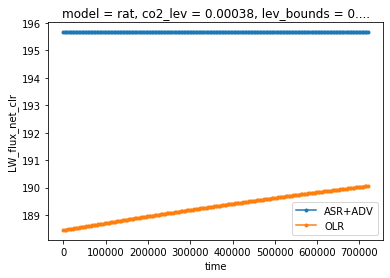

In [90]:
(month_ds_dict[month].sel(model = 'rat', co2_lev = co2)['SW_flux_net_clr'][0]+energy_budget_df.loc[month,'rat']['ATM_adv']).plot(marker = '.', label = 'ASR+ADV')
month_ds_dict[month].sel(model = 'rat', co2_lev = co2)['LW_flux_net_clr'][0].plot(marker = '.', label = 'OLR')
plt.legend()

#### greenhouse effect

#### plot the temperature difference between double and normal CO2 scenario

In [97]:
month = 'June'

(700, -50)

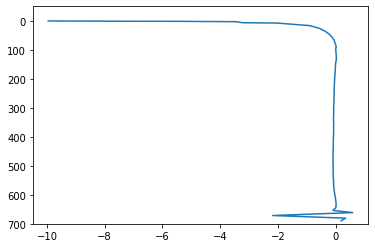

In [98]:
plt.plot((month_ds_dict[month].sel(
    model = 'rat', co2_lev = .00076, time = 200*3600)['T'] - month_ds_dict[month].sel(
    model = 'rat', co2_lev = .00038, time = 200*3600)['T']), month_ds_dict[month]['lev_full'])
plt.ylim(700,-50)

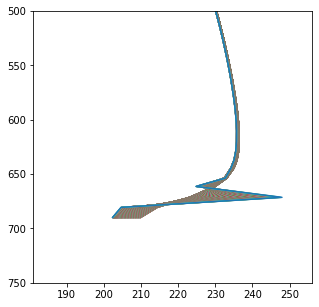

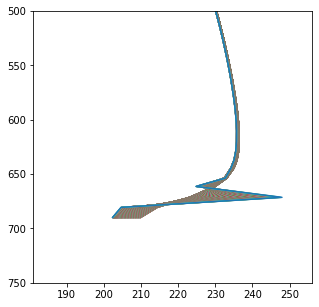

In [99]:
for co2 in [.00038,.00076]:
    fig, ax = plt.subplots(figsize = [5,5])
    for t in month_ds_dict[month]['time'].values:
        plt.plot(month_ds_dict[month].sel(
            model = 'rat', co2_lev = .00038, time = t)['T'],  month_ds_dict[month]['lev_full'])
        plt.ylim(750,500)

#### solar insolation

#### absorption coefficients and pressure

In [22]:
# estimate the absorption coefficient for CO2 = 1e-4 m2/kg
# P*CO2 mixing ratio * absorption coefficient / g = 1
# so g/CO2 mixing ratio /absorption coefficient = P

g = 9.8 #m/s2
mmr = 200*1e-6#ppm
abs_coef = 1

P = g/(mmr*abs_coef) #kg*s2/ m
P/100

490.00000000000006

In [207]:
wl = 15 #um
wn = 1/wl * 1e4
wn

666.6666666666666

#### standard atmosphere vs antarctic

In [259]:
#### compare between our antarctic version and a normal atmosphere
alb = 0.25
#  State variables (Air and surface temperature)
state = climlab.column_state(num_lev=30)
#  Parent model process
rcm = climlab.TimeDependentProcess(state=state)
#  Fixed relative humidity
h2o = climlab.radiation.ManabeWaterVapor(state=state)
#  Couple water vapor to radiation
rad = climlab.radiation.RRTMG(state=state, specific_humidity=h2o.q, albedo=alb)
#  Convective adjustment
conv = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate=6.5)
#  Couple everything together
rcm.add_subprocess('Radiation', rad)
rcm.add_subprocess('WaterVapor', h2o)
rcm.add_subprocess('Convection', conv)
#  Run the model
rcm.integrate_years(1)


Opened data from /opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9993368783782377 years.


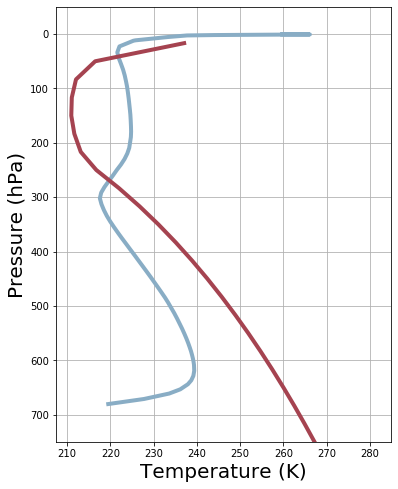

In [263]:
fig, ax = plt.subplots(figsize = [6,8])
colors=cm.twilight(np.linspace(0,1,8))
for month in ['March']:
    #plot our antarctic atmosphere
    x = np.asarray(results_dict[0]['Tatm'][0.00038][month])
    y = results_dict[0]['lev'][0.00038][month]
    plt.plot(x, y, c = colors[1], lw = 4)
    
    #plot standard atmosphere
    plt.plot(rcm.state['Tatm'], rcm.lev, c= colors[5], lw = 4)
    
    #labels and lims
    plt.ylabel('Pressure (hPa)', fontsize = 20)
    plt.xlabel('Temperature (K)', fontsize = 20)
    plt.ylim([750,-50])
plt.grid()
plt.savefig('../figures/stp_antarctic_comp.png', dpi = 150, bbox_inches = 'tight')

In [ ]:
for month in months:
    for co2 in co2_lev:
        for time in np.arange(0,((steps+1)*timestep),timestep):
            for model in model_dict.keys():
                
                #TOA Frad
                month_ds_dict[month]['F_rad_toa'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.asarray(month_ds_dict[month]['SW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[0]) - np.asarray(month_ds_dict[month]['LW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[0]) #W/m2

                #Surface Frad
                month_ds_dict[month]['F_rad_sfc'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.asarray(month_ds_dict[month]['SW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[-1]) - np.asarray(month_ds_dict[month]['LW_flux_net_clr'].sel(co2_lev = co2, time = time, model = model)[-1]) #W/m2

                #Surface Fturb
                month_ds_dict[month]['F_turb_sfc'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.asarray(month_ds_dict[month]['turbulent_flux'].sel(co2_lev = co2, time = time, model = model)[-1]) #W/m2

                month_ds_dict[month]['F_sfc'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = model_dict[model][F_rad_sfc].loc[dict(co2_lev = co2, time = time, model = dict_name)] - model_dict[model][F_turb_sfc].loc[dict(co2_lev = co2, time = time, model = dict_name)]
                #dT/dt
                month_ds_dict[month]['total_atm_hr'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = ((np.asarray(month_ds_dict[month]['T'].sel(co2_lev = co2, time = time+timestep, model = model)) - 
                                np.asarray(month_ds_dict[month]['T'].sel(co2_lev = co2, time = time, model = model)))[:-1]/np.asarray(timestep)) #K/s

                #dz
                month_ds_dict[month]['delta_z'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.diff(month_ds_dict[month]['z_bounds']) #surface to atmosphere #m

                #heat capacity (density*cp)
                month_ds_dict[month]['R'] = 8.314 #J/mol/K
                month_ds_dict[month]['MW_air'] = 0.0289647 #kg/mol
                month_ds_dict[month]['pressure_TOA'] = 100*month_ds_dict[month]['lev'][-1] #pascal (kg/m/s2)
                month_ds_dict[month]['density_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = (month_ds_dict[month]['MW_air']*100*month_ds_dict[month]['lev'])/(np.asarray(month_ds_dict[month]['T'].sel(co2_lev = co2, time = time, model = model)[:-1]) * month_ds_dict[month]['R']) #kg/m^3
                month_ds_dict[month]['cp_air'] = 1003 #specific heat of air (at 250 K) J/(kg*K)
                month_ds_dict[month]['heat_capacity_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = month_ds_dict[month]['density_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)]*month_ds_dict[month]['cp_air']

                #atmospheric heat content rate at each level
                month_ds_dict[month]['total_atm_heat_content_rate'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = month_ds_dict[month]['total_atm_hr'].loc[dict(co2_lev = co2, time = time, model = dict_name)] * month_ds_dict[month]['heat_capacity_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)] * month_ds_dict[month]['delta_z'].loc[dict(co2_lev = co2, time = time, model = dict_name)] #W/m2

                #advective flux at each level
                month_ds_dict[month]['total_adv_flux'].loc[dict(co2_lev = co2, time = time, model = dict_name)] = np.asarray(month_ds_dict[month]['advection'].sel(co2_lev = co2, time = time, model = model)[:-1]) * month_ds_dict[month]['heat_capacity_atm'].loc[dict(co2_lev = co2, time = time, model = dict_name)] * month_ds_dict[month]['delta_z'].loc[dict(co2_lev = co2, time = time, model = dict_name)] #W/m2
                
                